# Лабораторная работа 5. AutoML

**Выполнил**: Подцепко И.С., уч. группа M4138.

In [1]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import warnings

from optuna.trial import Trial
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from types import SimpleNamespace

Кодирование сверточного слоя:

In [57]:
def encode_convolution(layer):
    result = [layer.out_channels]
    result.extend(list(layer.kernel_size))
    result.extend(list(layer.stride))
    result.extend(list(layer.padding))
    return np.array(result)


print(
    "Conv2d:",
    encode_convolution(
        nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=3,
            stride=(1, 1),
            padding=4,
        )
    ),
)

Conv2d: [64  3  3  1  1  4  4]


Кодирование слоя пуллинга:

In [47]:
def encode_as_pair(value):
    if type(value) in [int, float]:
        return [value, value]
    return list(value)


def encode_pooling(layer):
    return np.array(encode_as_pair(layer.kernel_size) + encode_as_pair(layer.stride))


print(
    "MaxPool2d:",
    encode_pooling(
        nn.MaxPool2d(
            kernel_size=3,
            stride=(1, 2),
        )
    ),
)

MaxPool2d: [3 3 1 2]


Кодирование линейного слоя:

In [49]:
def encode_linear(layer):
    return np.array([layer.out_features])


print(
    "linear:",
    encode_linear(nn.Linear(in_features=128, out_features=64)),
)

linear: [64]


In [54]:
def encode_padding(_):
    return np.array([])

In [67]:
LAYER_TYPES = {nn.Conv2d, nn.MaxPool2d, nn.Linear}
TYPES_META_INFO = {
    None: (0, encode_padding),
    nn.Conv2d: (1, encode_convolution),
    nn.MaxPool2d: (2, encode_pooling),
    nn.Linear: (3, encode_linear),
}

MAX_ENCODED_LAYER_LENGHT = 7


def encode_layer(layer):
    layer_type = type(layer)
    if layer_type not in LAYER_TYPES:
        layer_type = None

    layer_type_id, encoder = TYPES_META_INFO[layer_type]

    encoded_id = [0] * len(TYPES_META_INFO)
    encoded_id[layer_type_id] = 1

    encoded_params = encoder(layer)
    encoded_params = np.pad(
        encoded_params,
        (0, MAX_ENCODED_LAYER_LENGHT - len(encoded_params)),
        mode="constant",
        constant_values=0,
    )

    return np.concat([encoded_id, encoded_params]).astype(np.float32)


for layer in [
    None,
    nn.Conv2d(
        in_channels=3,
        out_channels=8,
        kernel_size=3,
        stride=(1, 1),
        padding=4,
    ),
    nn.MaxPool2d(
        kernel_size=3,
        stride=(1, 2),
    ),
    nn.Linear(in_features=128, out_features=8),
]:
    print(encode_layer(layer))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 8. 3. 3. 1. 1. 4. 4.]
[0. 0. 1. 0. 3. 3. 1. 2. 0. 0. 0.]
[0. 0. 0. 1. 8. 0. 0. 0. 0. 0. 0.]


Далее вводим ограничение на число слоев, кодируем слои, пока не перешли его и дополняем padding'ами.


Идеи по обработке ошибок:
   1. Заменять параметры значениями по-умолчанию;
   2. Искать "ближайшую" корректную архитектуру;
   3. Структурировать генерацию: сначала последовательность сверточных слоев, затем последовательность полносвязных слоев.

## Поиск гиперпараметров

Описание набора данных с [официального сайта](https://www.cs.toronto.edu/~kriz/cifar.html):

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [2]:
ROOT = "../../data/cifar10"
TRANSFORMS = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
BATCH_SIZE = 512

In [3]:
def get_cifar10_loader(
    train: bool,
):
    return DataLoader(
        datasets.CIFAR10(root=ROOT, train=train, download=True, transform=TRANSFORMS),
        batch_size=BATCH_SIZE,
        shuffle=train,
    )

In [4]:
train_loader = get_cifar10_loader(train=True)
test_loader = get_cifar10_loader(train=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class CNN(nn.Module):
    def __init__(
        self,
        n_conv_layers: int,
        initial_out_channels: int,
        initial_kernel_size: int,
        activation: nn.Module,
        classifier_hidden_features: int | None,
        dropout_rate: float | None,
    ):
        assert dropout_rate is None or classifier_hidden_features is not None

        super(CNN, self).__init__()

        out_channels = [initial_out_channels * 2**i for i in range(n_conv_layers)]
        kernel_sizes = [
            max(1, initial_kernel_size - i * 2) for i in range(n_conv_layers)
        ]

        feature_extraction = []
        in_channels = 3
        for out_channels, kernel_size in zip(out_channels, kernel_sizes):
            feature_extraction.extend(
                [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,  # to save shape
                    ),
                    activation,
                    nn.MaxPool2d(kernel_size=2),
                ]
            )
            in_channels = out_channels

        self.feature_extraction = nn.Sequential(*feature_extraction)

        classifier = [nn.Flatten()]

        input_size = 32 // (2**n_conv_layers)
        in_features = in_channels * input_size**2

        if classifier_hidden_features is not None:
            classifier.extend(
                [
                    nn.Linear(
                        in_features=in_features, out_features=classifier_hidden_features
                    ),
                    nn.ReLU(),
                ]
            )
            in_features = classifier_hidden_features
            if dropout_rate is not None:
                classifier.append(nn.Dropout(dropout_rate))

        classifier.append(nn.Linear(in_features=in_features, out_features=10))

        self.classifier = nn.Sequential(*classifier)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.classifier(x)
        return x

In [6]:
import torch.optim.optimizer


def train_and_evaluate(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
):
    model = model.to(DEVICE)

    for i in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

In [7]:
def suggest_hyperparameters(trial: Trial):
    model_params = {
        "n_conv_layers": trial.suggest_int("n_conv_layers", 1, 4),
        "initial_out_channels": trial.suggest_categorical(
            "initial_out_channels", [8, 16, 32]
        ),
        "initial_kernel_size": trial.suggest_categorical(
            "initial_kernel_size", [3, 5, 7]
        ),
        "activation": (
            nn.ReLU()
            if trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"]) == "ReLU"
            else nn.LeakyReLU()
        ),
    }

    use_hidden_layer = trial.suggest_int("n_fc_layers", 1, 2) == 2
    model_params["classifier_hidden_features"] = (
        trial.suggest_categorical("classifier_hidden_features", [128, 256])
        if use_hidden_layer
        else None
    )

    use_dropout = use_hidden_layer and trial.suggest_categorical(
        "use_droput", [True, False]
    )

    model_params["dropout_rate"] = (
        trial.suggest_float("dropout_rate", 0.1, 0.5) if use_dropout else None
    )

    training_params = {
        "epochs": trial.suggest_int("epochs", 15, 45),
    }

    return SimpleNamespace(model_params=model_params, training_params=training_params)

In [8]:
class LoggingContext:
    def __init__(self, level):
        self.level = level
        self.previous_level = None

    def __enter__(self):
        self.previous_level = optuna.logging.get_verbosity()
        optuna.logging.set_verbosity(self.level)

    def __exit__(self, exc_type, exc_val, exc_tb):
        optuna.logging.set_verbosity(self.previous_level)

In [74]:
def test_objective(trial: Trial) -> float:
    params = suggest_hyperparameters(trial)
    summary(CNN(**params.model_params), (3, 32, 32))
    return 0


with LoggingContext(optuna.logging.CRITICAL):
    study = optuna.create_study(study_name="Test")
    study.optimize(test_objective, n_trials=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]           1,184
              ReLU-2            [-1, 8, 32, 32]               0
         MaxPool2d-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           3,216
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           2,112
             ReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                  [

In [10]:
def objective(trial):
    params = suggest_hyperparameters(trial)
    model = CNN(**params.model_params)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return train_and_evaluate(
        model,
        train_loader,
        test_loader,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        **params.training_params
    )

In [11]:
study = optuna.create_study(
    study_name="Search DCN for CIFAR10",
    direction="maximize",
)
study.optimize(objective, n_trials=300)

[I 2024-12-21 01:14:19,607] A new study created in memory with name: Search DCN for CIFAR10
[I 2024-12-21 01:15:49,946] Trial 0 finished with value: 0.7247 and parameters: {'n_conv_layers': 4, 'initial_out_channels': 32, 'initial_kernel_size': 5, 'activation': 'LeakyReLU', 'n_fc_layers': 2, 'classifier_hidden_features': 256, 'use_droput': False, 'epochs': 23}. Best is trial 0 with value: 0.7247.
[I 2024-12-21 01:16:56,425] Trial 1 finished with value: 0.7177 and parameters: {'n_conv_layers': 2, 'initial_out_channels': 32, 'initial_kernel_size': 7, 'activation': 'LeakyReLU', 'n_fc_layers': 1, 'epochs': 17}. Best is trial 0 with value: 0.7247.
[I 2024-12-21 01:19:31,299] Trial 2 finished with value: 0.6616 and parameters: {'n_conv_layers': 2, 'initial_out_channels': 16, 'initial_kernel_size': 3, 'activation': 'ReLU', 'n_fc_layers': 1, 'epochs': 44}. Best is trial 0 with value: 0.7247.
[I 2024-12-21 01:21:42,060] Trial 3 finished with value: 0.7 and parameters: {'n_conv_layers': 4, 'initi

In [12]:
print("Best hyperparameters:", study.best_trial.params)
print("Best accuracy:", study.best_value)

Best hyperparameters: {'n_conv_layers': 3, 'initial_out_channels': 32, 'initial_kernel_size': 7, 'activation': 'LeakyReLU', 'n_fc_layers': 2, 'classifier_hidden_features': 128, 'use_droput': True, 'dropout_rate': 0.45978776796367166, 'epochs': 20}
Best accuracy: 0.7684


In [70]:
_ = test_objective(study.best_trial)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,736
         LeakyReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          51,264
         LeakyReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
         LeakyReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                  [-1, 128]         262,272
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [13]:
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)
visualizer = optuna.visualization.matplotlib

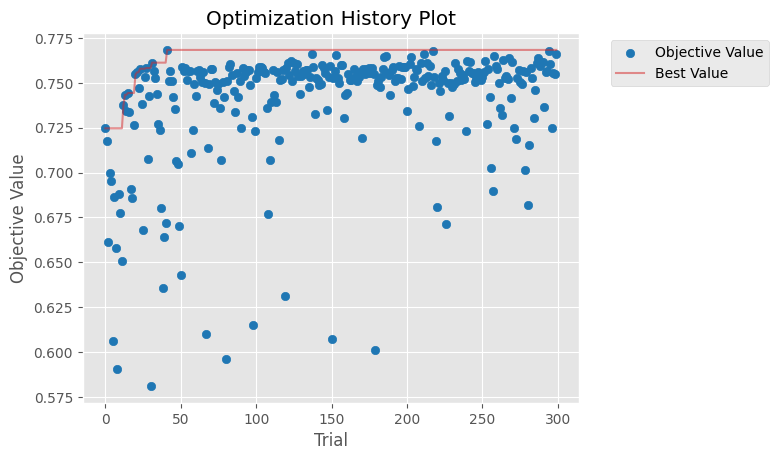

In [14]:
_ = visualizer.plot_optimization_history(study)

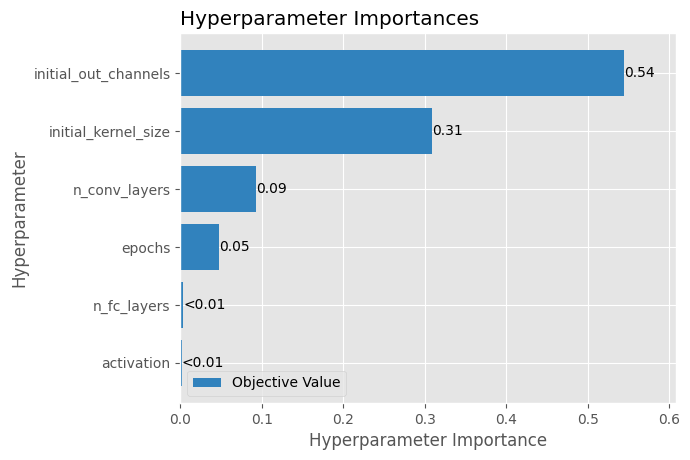

In [15]:
_ = visualizer.plot_param_importances(study)

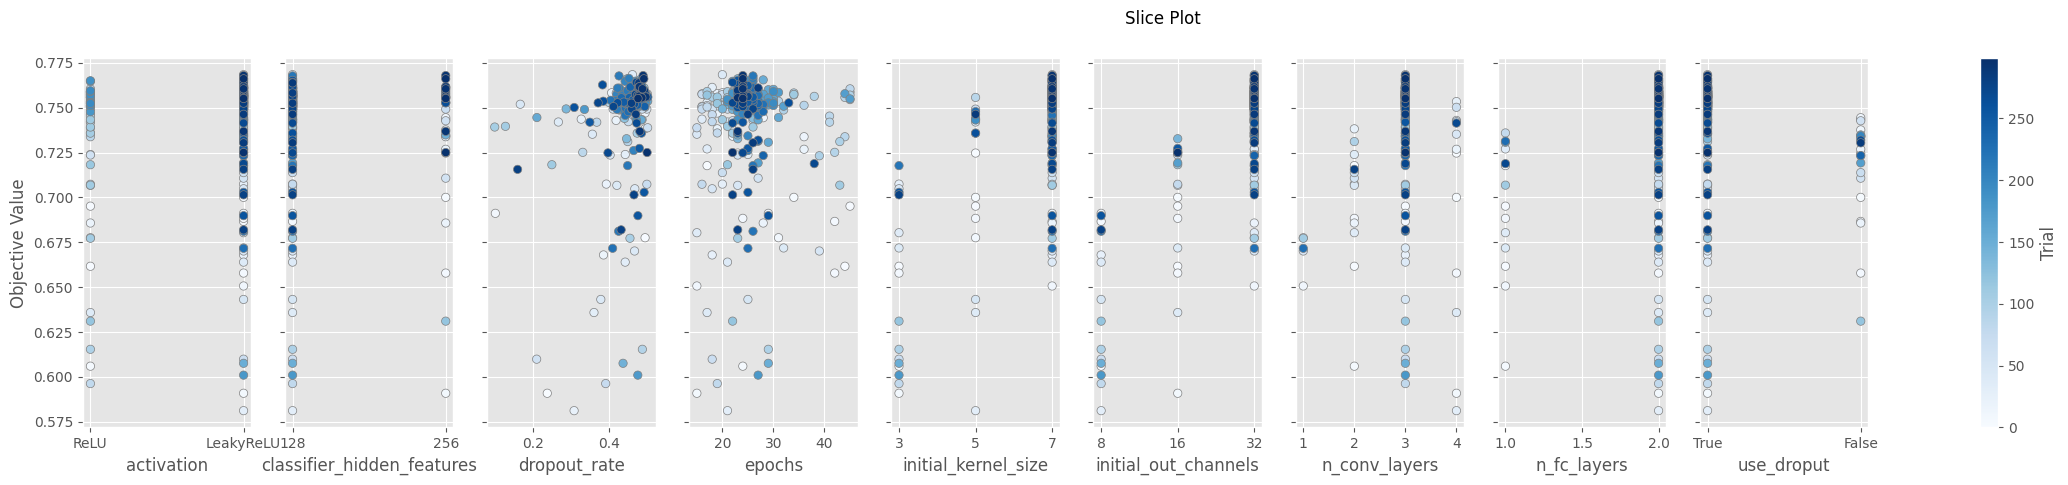

In [16]:
_ = visualizer.plot_slice(study)

**Выводы**:
1. Архитектуру нейронной сети можно векторизовать. Один из возможных подходов: кодировать тип слоя, а затем — его гиперпараметры. Для удобства параметры каждого слоя заполнять нулями и ограничивать число слоев. Если их не хватает — также заполнять нулями;
2. Для поиска гиперпараметров можно использовать библиотеку `optuna`;
3. Перебирать можно гиперпараметры модели и гиперпараметры для обучения (число эпох, learning rate, тип оптимизатора и т. д.);
4. Найдена архитектура сверточной нейронной сети, которая дает точность 76.84% на CIFAR10. Это заметно выше, чем у большинства других, которые перебирались в процессе поиска гиперпараметров.